# Analysis notebook for: How much research shared on Facebook is hidden from public view?

This notebook produces all results and figures in the article.

Figures are plotted to the *figures/* directory.
Tables are saved to the *tables/* directory.

**Article outline and outputs**

1. Introduction
2. Background
    - Figure 1 (static)
    - Table 1 (static)
3. Methodology
    - Table 2 (static)
4. Results
    1. Coverage
        - [Table 3](#Table-3)
        - [Figure 2](#Figure-2)
        - [Table 4](#Table-4)
        - [Figure 3](#Figure-3)
        - [Figure 4](#Figure-4)
    2. Engagement counts
        - [Table 5](#Table-5)
        - [Table 6](#Table-6)
        - [Figure 5](#Figure-5)
        - [Figure 6](#Figure-6)
        - [Figure 7](#Figure-7)
5. Discussion and Conclusion
6. Appendices
    - [Table A1](#Table-A1)
    - [Table B1](#Table-B1)
7. Supplemental material
    - [Figure 8](#Figure-8)
    - [Figure 9](#Figure-9) 

In [1]:
import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gspread_dataframe import set_with_dataframe
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn2, venn3, venn3_circles
from oauth2client.service_account import ServiceAccountCredentials
from scipy import stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

tqdm.pandas()

The following presents an implementation of _partial log binning_ following Milojević (2010)

In [2]:
def thresh(bin_size):
    x = 1
    while True:
        diff = np.log10(x+1) - np.log10(x)
        if diff < bin_size:
            return x +1
        x = x + 1

def partial_log_binning(data_counts, bin_size=0.1):
    n_bins = 1/bin_size
    binning_threshold = thresh(bin_size)

    log_data = np.log10(data_counts)
    log_index = np.log10(log_data.index)

    logbins = np.linspace(np.log10(binning_threshold)+0.1,
                          np.log10(max(data)),
                          ((np.log10(max(data))-np.log10(binning_threshold)+0.1)//0.1)+1)

    binned_xs = []
    binned_vals = []      
    
    for i in range(1, binning_threshold+1):      
        if i in log_data.index:
            binned_vals.append(log_data.loc[i])
            binned_xs.append(np.log10(i))
    
    for b in logbins:       
            vals = (b-.05 <= log_index) & (log_index < b+.05)
            vs = data_counts[vals]
            if len(vs)>0:
                n = np.ceil(10**(b+.05) - 10**(b-.05))
                if n == 0:
                    continue
                binned_vals.append(np.log10(vs.sum()/n))
                binned_xs.append(b)
    return binned_xs, binned_vals  

# Initialization

## Configuration

In [3]:
# Seaborn styles
sns.set_style("whitegrid")

# Matplotlib figure configuration fonts and figsizes
plt.rcParams.update({
    'font.family':'sans-serif',
    'font.size': 16.0,
    'text.usetex': False,
    'figure.figsize': (11.69,8.27)
})

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

In [4]:
### Optional ###
# Set up GSpread connection to push dataframes to Google Spreadsheets
# Instructions can be found at https://gspread.readthedocs.io/en/latest/

push_to_gspread = False

if push_to_gspread:
    scope = ['https://spreadsheets.google.com/feeds',
             'https://www.googleapis.com/auth/drive']

    credentials = ServiceAccountCredentials.from_json_keyfile_name('My Project-d9fa71152fe8.json', scope)

    gc = gspread.authorize(credentials)
    sh =  gc.open("PLOS Paper - Tables")

## Load data

In [5]:
articles_csv = "data/articles.csv"

figs = "figures/"
tables = "tables/"

save_tables = True
save_figs = True

In [6]:
# Load data
articles = pd.read_csv(articles_csv, index_col="doi", parse_dates=['publication_date'])

## Helpers

A few variables to quickly access slices/sets of the dataset

In [9]:
# A few useful sets to index various slices of the articles
aes_set = set(articles['AES'].dropna().index.tolist())
aer_set = set(articles['AER'].dropna().index.tolist())
aec_set = set(articles['AEC'].dropna().index.tolist())

pos_set = set(articles['POS'].dropna().index.tolist())
tw_set = set(articles['TW'].dropna().index.tolist())

any_shares = pos_set.union(aes_set)
both_shares = pos_set.intersection(aes_set)
any_engagement = aes_set.union(aer_set).union(aec_set)

In [10]:
# three main metrics
metrics = ['AES', 'POS', 'TW']

# Results

## Table 3

In [11]:
x = articles[metrics + ['year']].groupby("year").count()
x['All articles'] = articles.groupby("year").count()['title']

df_cross_metrics = x.copy()
df_cross_metrics.loc['All years'] = df_cross_metrics.sum(axis=0)

for i in df_cross_metrics.index.tolist():
    df_cross_metrics.loc[i, metrics] = df_cross_metrics.loc[i, metrics].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/df_cross_metrics.loc[i, 'All articles'])
    )

df_cross_metrics.index.name = ""

if push_to_gspread:
    wks = sh.worksheet("Coverage - Methods")
    set_with_dataframe(wks, df_cross_metrics.reset_index())

if save_tables:
    df_cross_metrics.to_csv(tables + "table_3_coverage_aes_pos_tw.csv")
    
df_cross_metrics

,AES,POS,TW,All articles
,,,,
2015,"8,596 (33.8%)","3,981 (15.7%)","16,976 (66.8%)",25427
2016,"6,992 (37.2%)","3,058 (16.3%)","13,807 (73.4%)",18809
2017,"5,827 (33.1%)","2,584 (14.7%)","12,281 (69.7%)",17612
All years,"21,415 (34.6%)","9,623 (15.6%)","43,064 (69.6%)",61848


## Figure 2

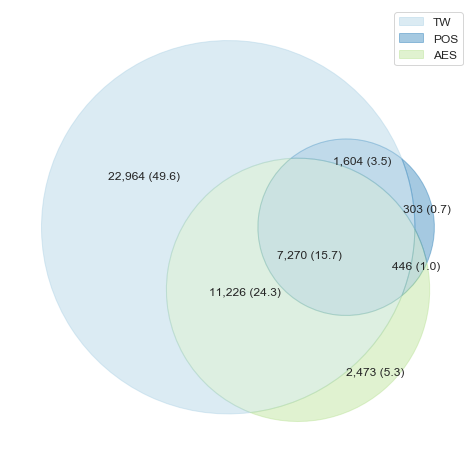

In [12]:
pdf = articles

total = len(pos_set.union(aes_set).union(tw_set))

v = venn3([tw_set, pos_set, aes_set],
      set_labels=('', '', ''),
      subset_label_formatter=lambda x: "{:,} ({:.1f})".format(x, 100*x/total));

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('010').set_color(cp3[1])
v.get_patch_by_id('001').set_color(cp3[2])

v.get_patch_by_id('110').set_color(np.add(cp3[0], cp3[1])/2)
v.get_patch_by_id('011').set_color(np.add(cp3[1], cp3[2])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0], cp3[2])/2)

v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(10)
for text in v.subset_labels:
    text.set_fontsize(12)

plt.gca().legend(handles=[v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')],
                 labels=["TW", "POS", "AES"], prop={'size': 12});

if save_figs:
    plt.savefig(figs + "figure_2_coverage_aes_pos_tw.png", bbox_inches="tight")

## Table 4


In [13]:
df = articles[['AES', 'POS']].dropna(how="all")
df = pd.concat([df, articles[['year']]], join="inner", axis=1)

x = df.groupby("year").apply(lambda x: sum(~x['AES'].isna() & x['POS'].isna())).to_frame("AES")
x = pd.concat([x, df.groupby("year").apply(lambda x: sum(~x['AES'].isna() & ~x['POS'].isna())).to_frame("AES and POS")], axis=1)
x = pd.concat([x, df.groupby("year").apply(lambda x: sum(x['AES'].isna() & ~x['POS'].isna())).to_frame("POS")], axis=1)

df_overlap_coverage = x.copy()
df_overlap_coverage.loc['All years'] = df_overlap_coverage.sum(axis=0).astype(int)
df_overlap_coverage['Any FB'] = df_overlap_coverage.sum(axis=1)

cols = ["AES", "AES and POS", "POS"]
for i in [2015, 2016, 2017, 'All years']:
    df_overlap_coverage.loc[i, cols] = df_overlap_coverage.loc[i, cols].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/df_overlap_coverage.loc[i, "Any FB"]))
    
df_overlap_coverage.index.name = ""

if push_to_gspread:
    wks = sh.worksheet("Coverage - Facebook")
    set_with_dataframe(wks, df_overlap_coverage.reset_index())
    
if save_tables:
    df_overlap_coverage.to_csv(tables + "table_4_coverage_facebook_methods.csv")

df_overlap_coverage

,AES,AES and POS,POS,Any FB
,,,,
2015,"5,414 (57.6%)","3,182 (33.9%)",799 (8.5%),9395
2016,"4,540 (59.8%)","2,452 (32.3%)",606 (8.0%),7598
2017,"3,745 (59.2%)","2,082 (32.9%)",502 (7.9%),6329
All years,"13,699 (58.7%)","7,716 (33.1%)","1,907 (8.2%)",23322


In [14]:
# Difference between AES and POS counts
articles['diff'] = articles['AES'] - articles['POS']

# Remove articles in Arts and Humanities
base = articles[~articles.discipline.isin(["Arts", "Humanities"])]
"Removed {} articles in Arts or Humanities".format(articles[articles.discipline.isin(["Arts", "Humanities"])].shape[0])

'Removed 17 articles in Arts or Humanities'

In [15]:
# Disciplinary analysis is based on the "discipline" column
# Other options: "grand_discipline", "specialty"
col = "discipline"

cov_disciplines = base.groupby(col)[metrics].apply(lambda x: x.count())
cov_disciplines['All articles'] = base.groupby(col)[metrics].size()
cov_disciplines = cov_disciplines.sort_values("All articles", ascending=False)

# Column names + order
cov_disciplines.index.name = "Discipline"

## Figure 3

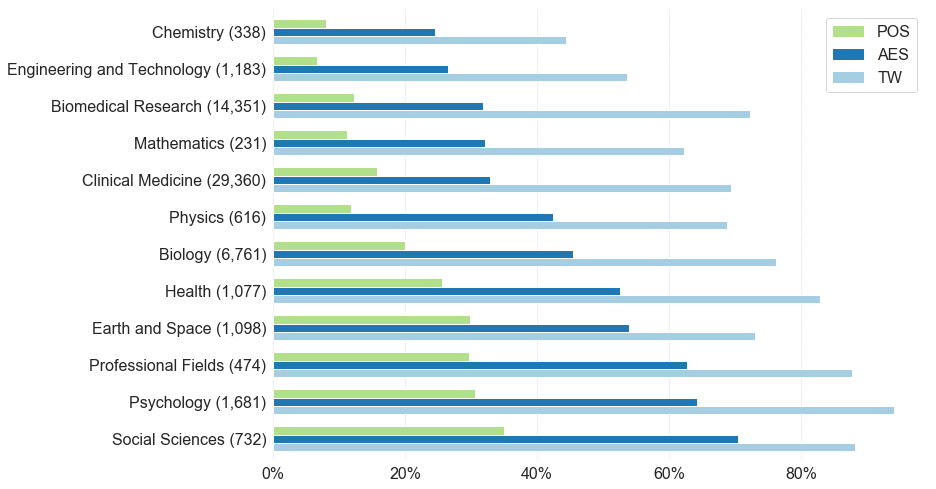

In [16]:
pdf = cov_disciplines[metrics].copy()
pdf = pdf.apply(lambda x: x.map(lambda y: 100*y/cov_disciplines.loc[x.name, "All articles"]), axis=1)
# pdf = pdf.sort_values("AES", ascending=False)

pdf.index = pdf.index.map(lambda x: "{} ({:,})".format(x, cov_disciplines.loc[x, "All articles"]))
pdf = pdf.sort_values(["AES"], ascending=False)
pdf = pdf[['POS', 'AES', "TW"][::-1]]

pdf.plot(kind="barh", colormap=ListedColormap(sns.color_palette("Paired", 3)), width=.65)

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[::-1], l[::-1])

plt.ylabel("")
plt.grid(False)
plt.grid(True, axis="x", linestyle=":")

ticks = plt.gca().get_xticks()[:-1]
plt.xticks(ticks, ["{}%".format(int(x)) for x in ticks])

sns.despine(top=True, bottom=True, left=True, right=True);

if save_figs:
    plt.savefig(figs + "figure_3_coverage_disciplines.png", bbox_inches="tight")

## Figure 4

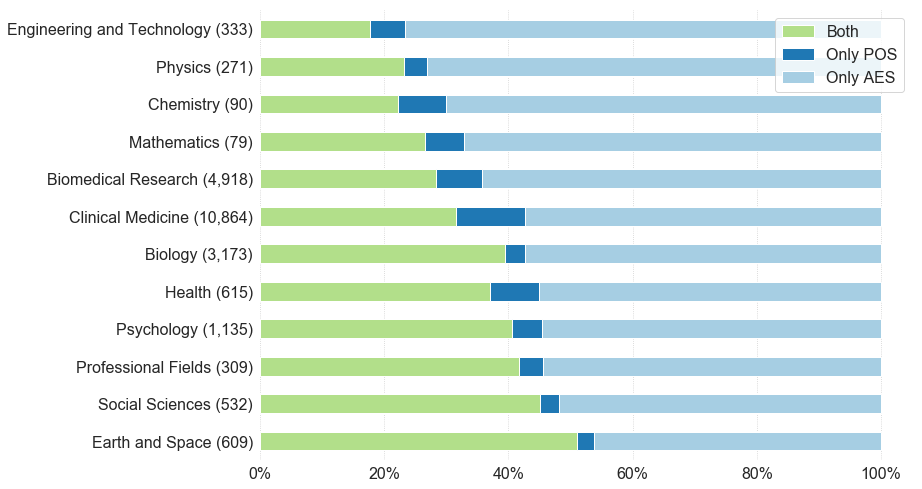

In [18]:
a = aes_set.difference(pos_set)
b = aes_set.intersection(pos_set)
c = pos_set.difference(aes_set)

any_fb_counts = base.reindex(aes_set.union(pos_set))[col].value_counts()
any_fb_counts.loc['Total'] = any_fb_counts.sum()

indices = [a, b, c]

dfs = []
for ix, label in enumerate(["Only AES", "Both", "Only POS"]):
    dois = set().union(*indices[ix:ix+1])
    x = base.reindex(dois)[col].value_counts()
    dfs.append(x.to_frame(label))

pdf = pd.concat(dfs, axis=1, sort=False)
pdf.index = pdf.index.map(lambda x: "{} ({:,})".format(x, any_fb_counts.loc[x]))

pdf = pdf.apply(lambda x: x.map(lambda y: 100*y/sum(x)), axis=1)
pdf = pdf.sort_values(by="Only AES")
pdf[['Both', 'Only POS', 'Only AES']].plot(kind="barh", stacked=True, colormap=ListedColormap(sns.color_palette("Paired", 3)[::-1]))

ticks = plt.gca().get_xticks()[:-1]
plt.xticks(ticks, ["{}%".format(int(x)) for x in ticks])

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(top=True, bottom=True, left=True, right=True)

if save_figs:
    plt.savefig(figs + "figure_4_coverage_facebook_methods.png", bbox_inches="tight")

In [19]:
pdf

,Only AES,Both,Only POS
Earth and Space (609),46.305419,51.067323,2.627258
Social Sciences (532),51.879699,45.112782,3.007519
Professional Fields (309),54.368932,41.747573,3.883495
"Psychology (1,135)",54.625551,40.528634,4.845815
Health (615),55.121951,37.073171,7.804878
"Biology (3,173)",57.295934,39.426410,3.277655
"Clinical Medicine (10,864)",57.382180,31.608984,11.008837
"Biomedical Research (4,918)",64.213095,28.385523,7.401383
Mathematics (79),67.088608,26.582278,6.329114
Chemistry (90),70.000000,22.222222,7.777778


In [22]:
binns = {}
alphas = {}

# straight line
def func(x, a, b):
    return a*x + b

for _ in ['AES', 'POS', 'TW']:
    data = articles[_].dropna()
    val_counts = data.value_counts().sort_index()
    
    x, y = partial_log_binning(val_counts, bin_size=0.1)
    
    binns[_] = x,y

    alpha, intercept = curve_fit(func, x, y)[0] # your data x, y to fit
    alphas[_] = np.abs(alpha)

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


## Table 5

In [23]:
as_data = articles['AES'].dropna()
ps_data = articles['POS'].dropna()
tw_data = articles['TW'].dropna()

summary = pd.DataFrame()

# Base stats
summary['Count'] = articles[metrics].count()
summary['Min'] = articles[metrics].min()
summary['Max'] = articles[metrics].max()

# summary['Med'] = articles[metrics].median()
summary['Geom-Mean'] = [stats.gmean(as_data),
                        stats.gmean(ps_data),
                        stats.gmean(tw_data)]

# Fitted powerlaw
summary['α'] = [alphas['AES'], alphas['POS'], alphas['TW']]
summary.index.name = ""

if push_to_gspread:
    wks = sh.worksheet("Volumne - Distributions")
    set_with_dataframe(wks, summary.reset_index().round(2))

if save_tables:
    summary.round(2).to_csv(tables + "table_5_descriptive_stats_distros.csv")
    
summary.round(2)

,Count,Min,Max,Geom-Mean,α
,,,,,
AES,21415,1.0,12473.0,2.36,1.95
POS,9623,1.0,186.0,1.53,2.54
TW,43064,1.0,8626.0,3.22,2.11


## Table 6

In [24]:
if save_tables:
    articles[metrics].fillna(0).corr("spearman").round(2).to_csv(tables + "table_6_spearman_corr.csv")
    

articles[metrics].fillna(0).corr("spearman").round(2)

,AES,POS,TW
AES,1.00,0.48,0.45
POS,0.48,1.00,0.36
TW,0.45,0.36,1.00


## Figure 5

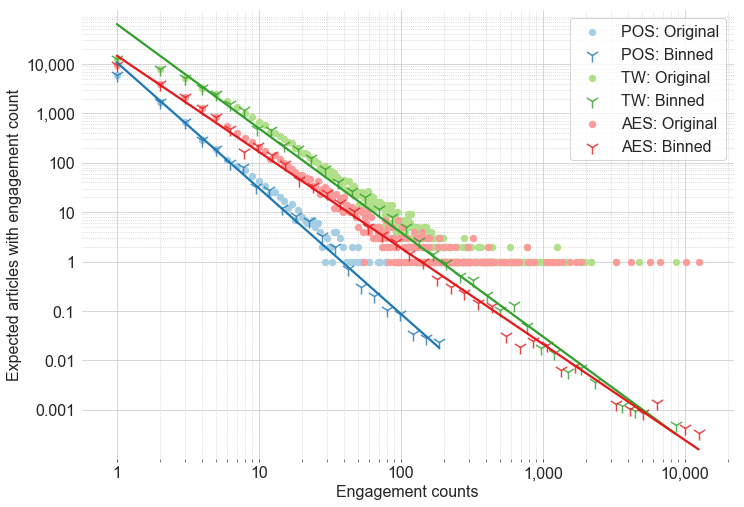

In [25]:
fig = plt.figure()
ax = plt.gca()

for ix, (m, (x,y)) in enumerate(list(binns.items())):
    data = {
        'x':x,
        'y':y
    }
    pdf = pd.DataFrame(data=data)
        
    val_counts = articles[m].dropna().value_counts()
    val_counts = np.log10(val_counts)
    val_counts.index = np.log10(val_counts.index)
    
    plt.scatter(x="index", y=m, data=val_counts.reset_index(),
                label="{}: Original".format(m), c=[cp10[2*ix]], alpha=1, s=40, marker="o",
                zorder=1)
    
    sns.regplot(x="x", y="y", data=pdf,
                label="{}: Binned".format(m), marker="1", color=cp10[2*ix+1],
                truncate=True, ci=False,
                scatter_kws={'s':200, 'zorder':2})
    
plt.legend()

plt.ylim(-4,5.1)
# plt.xlim(-.1,4)

xbins = [1, 10, 100, 1000, 10000]
plt.xticks(np.log10(xbins), ["{:,}".format(_) for _ in xbins]);

ybins = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.yticks(np.log10(ybins), ["{:,}".format(_) for _ in ybins]);

min_ticks = [2,3,4,5,6,7,8,9]
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])

ax.tick_params(axis="x", which="both", bottom=True, length=3)
ax.tick_params(axis="y", which="both", bottom=True, length=3)

# locmin = ticker.LogLocator(subs=subs, numticks=200, numdecs=5)
locmin = ticker.FixedLocator(np.log10(min_ticks))

ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.grid(axis="both", which="minor", linestyle=":")

ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

# plt.grid(False)

plt.ylabel("Expected articles with engagement count")
plt.xlabel("Engagement counts")

sns.despine(bottom=True, top=True, left=True, right=True, ax=ax)

if save_figs:
    plt.savefig(figs + "figure_5_count_distributions.png", bbox_inches="tight")

In [26]:
print("AES > POS: {}".format(sum(articles['diff']>0)))
print("POS > AES: {}".format(sum(articles['diff']<0)))
print("AES == POS: {}".format(sum(articles['diff']==0)))

AES > POS: 5223
POS > AES: 466
AES == POS: 2027


## Figure 6

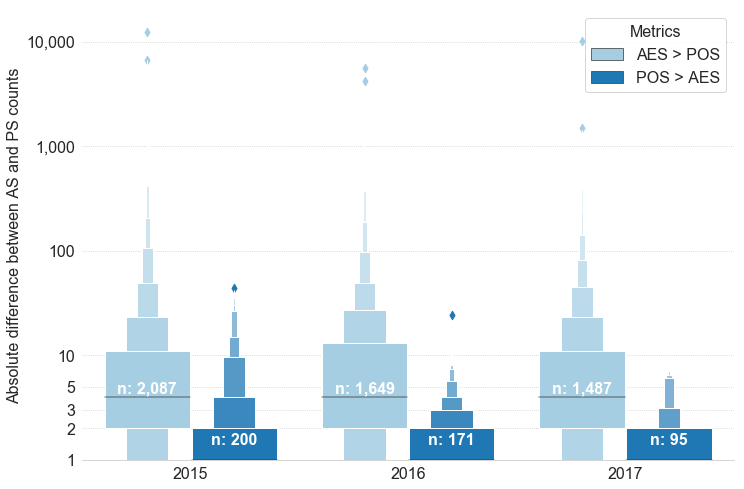

In [27]:
pdf = articles[['diff', 'year']].dropna()
pdf['year'] = pdf['year'].astype(str)
pdf = pdf[pdf['diff']!=0]

pdf["Metrics"] = pdf['diff']>0
pdf.Metrics.replace(True, "AES > POS", inplace=True)
pdf.Metrics.replace(False, "POS > AES", inplace=True)

pdf["diff"] = pdf["diff"].abs()

plt.figure()
sns.boxenplot(x="year", y="diff", hue="Metrics", dodge=True, data=pdf, palette=cm, saturation=1)

medians = pdf.groupby(['year', 'Metrics'])['diff'].median().tolist()
nobs = pdf.groupby(['year', 'Metrics'])['diff'].count().tolist()
nobs = ["n: {:,}".format(x) for x in nobs]

pos = [-.2, .2, .8, 1.2, 1.8, 2.2]

for x, y, label in zip(pos, medians, nobs):
    plt.text(x, y+.4, label,
             horizontalalignment='center', color='w', weight='bold')

plt.yscale("log")
yticks = [1,2,3,5,10,100,1000,10000]
plt.yticks(yticks, ["{:,}".format(_) for _ in yticks]);
plt.ylim(1, plt.gca().get_ylim()[1]);
plt.ylabel("Absolute difference between AS and PS counts")
plt.xlabel("")

plt.grid(axis="y", linestyle=":")
plt.grid(False, axis="x")

sns.despine(left=True, right=True, top=True)

if save_figs:
    plt.savefig(figs + "figure_6_letter_value_plot_count_difference.png", bbox_inches="tight")

## Figure 7

In [47]:
a = base[base['diff']>0].index
b = base[base['diff']<0].index
c = base[base['diff']==0].index

indices = [a, b, c]

dfs = []
for ix, label in enumerate(["AES > POS", "AES < POS", "AES == POS"]):
    x = base.reindex(indices[ix]).copy()
    x['diff'] = np.abs(x['diff'])
    x = x.melt(id_vars="discipline", value_vars=['diff'], value_name="Absolute difference between AES and POS")
    x['type'] = label
    dfs.append(x)
df = pd.concat(dfs, axis=0, sort=False)

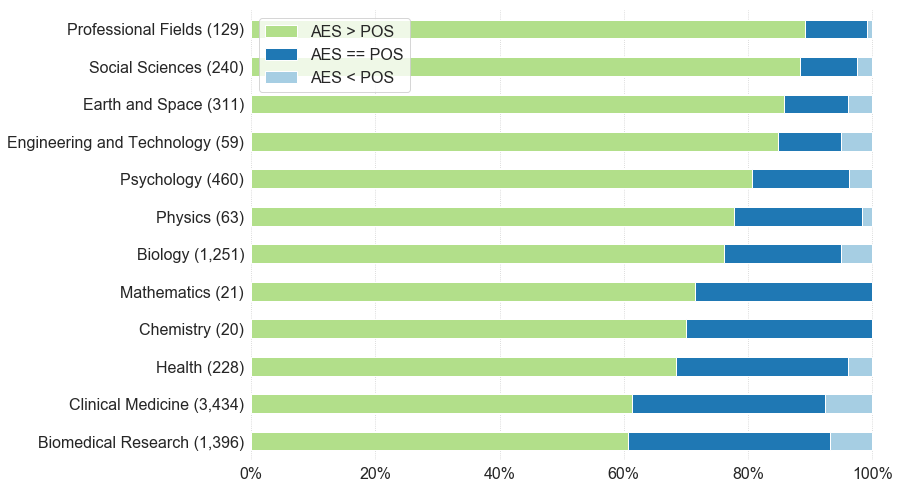

In [55]:
diff_disc_counts = base[~base['diff'].isna()][col].value_counts()

pdf = df.groupby([col, "type"])['variable'].count().to_frame().reset_index()
y = df.groupby([col])['variable'].count()

pdf['%'] = pdf.apply(lambda x: 100*x.variable/y[x[col]], axis=1)

pdf = pdf.pivot(index=col, columns="type")['%']
pdf = pdf[['AES > POS', 'AES == POS', "AES < POS"]]
pdf = pdf.sort_values('AES > POS')

pdf.index = pdf.index.map(lambda x: "{} ({:,})".format(x, diff_disc_counts.loc[x]))

pdf.plot(kind="barh", stacked=True, colormap=ListedColormap(sns.color_palette("Paired", 3)[::-1]))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l)

ticks = plt.gca().get_xticks()[:-1]
plt.xticks(ticks, ["{}%".format(int(x)) for x in ticks])

plt.ylabel("")
plt.xlabel("")

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(top=True, bottom=True, left=True, right=True)

if save_figs:
    plt.savefig(figs + "figure_7_AES_POS_comparison_disciplines.png", bbox_inches="tight")

## Table A1

In [17]:
# Format + Percentages
cov_disc_formatted = cov_disciplines.copy()
cov_disc_formatted.columns = [
    "AES (coverage)",
    "POS (coverage)",
    "TW (coverage)",
    "All articles (percentage)"]

cov_disc_formatted.loc['Total'] = cov_disc_formatted.sum()

cols = cov_disc_formatted.columns[0:3]
for i in cov_disc_formatted.index:
    cov_disc_formatted.loc[i, cols] = cov_disc_formatted.loc[i, cols].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/cov_disc_formatted.loc[i, "All articles (percentage)"]))

t = cov_disc_formatted["All articles (percentage)"][:-1].sum()
cov_disc_formatted["All articles (percentage)"] = cov_disc_formatted["All articles (percentage)"].map(
    lambda x: "{:,} ({:.1f}%)".format(x, 100*x/t))
    
if push_to_gspread:
    wks = sh.worksheet("Disciplines - Coverage")
    set_with_dataframe(wks, cov_disc_formatted.reset_index())

if save_tables:
    cov_disc_formatted.to_csv(tables + "table_A1_coverage_disciplines.csv")
    
cov_disc_formatted

,AES (coverage),POS (coverage),TW (coverage),All articles (percentage)
Discipline,,,,
Clinical Medicine,"9,668 (32.9%)","4,630 (15.8%)","20,387 (69.4%)","29,360 (50.7%)"
Biomedical Research,"4,554 (31.7%)","1,760 (12.3%)","10,379 (72.3%)","14,351 (24.8%)"
Biology,"3,069 (45.4%)","1,355 (20.0%)","5,150 (76.2%)","6,761 (11.7%)"
Psychology,"1,080 (64.2%)",515 (30.6%),"1,583 (94.2%)","1,681 (2.9%)"
Engineering and Technology,314 (26.5%),78 (6.6%),634 (53.6%),"1,183 (2.0%)"
Earth and Space,593 (54.0%),327 (29.8%),802 (73.0%),"1,098 (1.9%)"
Health,567 (52.6%),276 (25.6%),893 (82.9%),"1,077 (1.9%)"
Social Sciences,516 (70.5%),256 (35.0%),646 (88.3%),732 (1.3%)
Physics,261 (42.4%),73 (11.9%),424 (68.8%),616 (1.1%)


## Table B1

In [21]:
a = aes_set.difference(pos_set)
b = aes_set.intersection(pos_set)
c = pos_set.difference(aes_set)

indices = [a, b, c]

dfs = []
for ix, label in enumerate(["Only AES", "Both", "Only POS"]):
    x = base.reindex(indices[ix])[col].value_counts()
    dfs.append(x.to_frame(label))

pdf = pd.concat(dfs, axis=1, sort=False)
pdf.loc['Total'] = pdf.sum()

pdf['Any FB'] = pdf.sum(axis=1)
pdf['Public/Private (%)'] = np.round((pdf['Only POS'] + pdf['Both']) / (pdf['Only AES'] + pdf['Both']) * 100, 1)
pdf['POS/AES (%)'] = np.round(pdf['Only POS'] / (pdf['Only AES']) * 100, 1)

cols = pdf.columns[0:3]
for i in pdf.index:
    pdf.loc[i, cols] = pdf.loc[i, cols].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/any_fb_counts[i]))

pdf.index.name = "Discipline"

if push_to_gspread:
    wks = sh.worksheet("Disciplines - FB")
    set_with_dataframe(wks, pdf[["Any FB", "Only AES", "Both", "Only POS"]].reset_index())

if save_tables:
    pdf[["Any FB", "Only AES", "Both", "Only POS"]].to_csv(tables + "table_B1_coverage_facebook_methods.csv")
    
pdf[["Any FB", "Only AES", "Both", "Only POS"]]

,Any FB,Only AES,Both,Only POS
Discipline,,,,
Clinical Medicine,10864,"6,234.0 (57.4%)","3,434.0 (31.6%)","1,196.0 (11.0%)"
Biomedical Research,4918,"3,158 (64.2%)","1,396 (28.4%)",364 (7.4%)
Biology,3173,"1,818 (57.3%)","1,251 (39.4%)",104 (3.3%)
Psychology,1135,620 (54.6%),460 (40.5%),55 (4.8%)
Health,615,339 (55.1%),228 (37.1%),48 (7.8%)
Earth and Space,609,282 (46.3%),311 (51.1%),16 (2.6%)
Social Sciences,532,276 (51.9%),240 (45.1%),16 (3.0%)
Engineering and Technology,333,255 (76.6%),59 (17.7%),19 (5.7%)
Physics,271,198 (73.1%),63 (23.2%),10 (3.7%)


## Figure 8

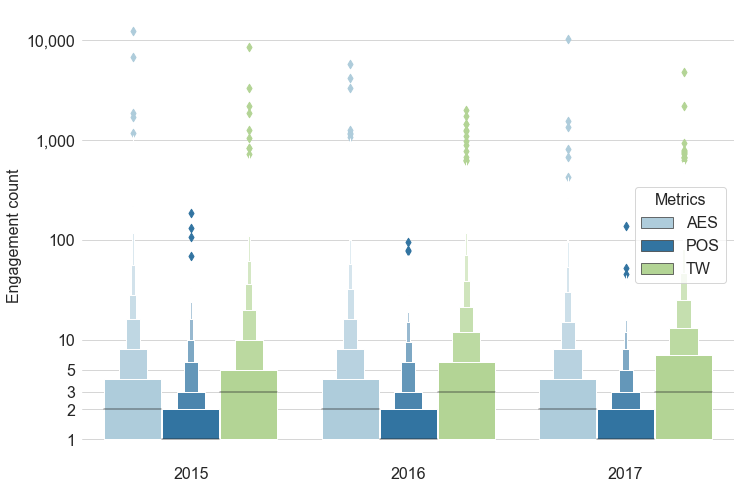

In [57]:
pdf = articles[metrics+["year"]]
pdf = pdf.melt(value_vars=metrics, value_name="Engagement count", id_vars="year", var_name="Metrics")

plt.figure()
sns.boxenplot(x="year", y="Engagement count", hue="Metrics", data=pdf, palette=cm)

plt.yscale("log")

yticks = [1,2,3,5,10,100,1000,10000]
plt.yticks(yticks, ["{:,}".format(_) for _ in yticks]);
plt.xlabel("")
sns.despine(top=True, bottom=True, left=True, right=True)

if save_figs:
    plt.savefig(figs + "supplemental_fig_8_metrics_over_years.png", bbox_inches="tight")

## Figure 9

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches w

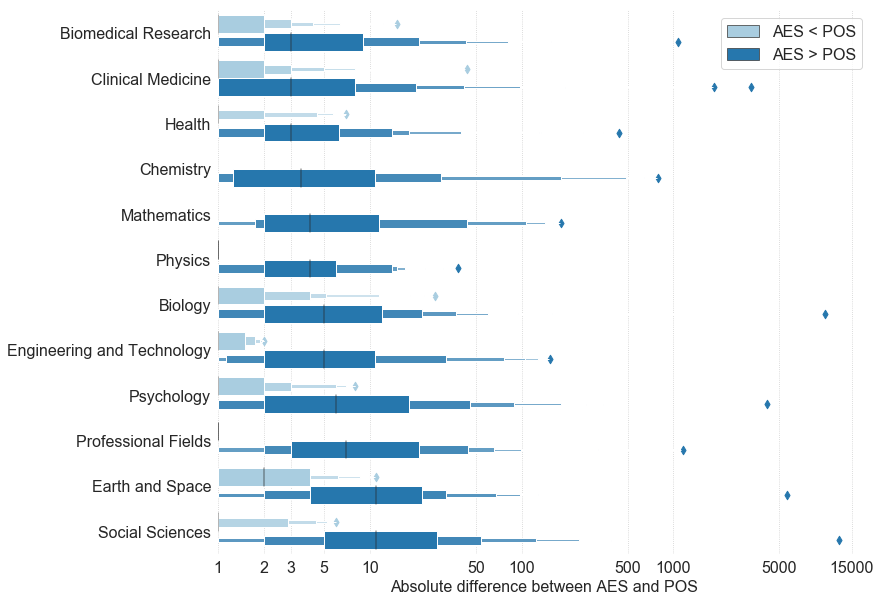

In [54]:
pdf = df.dropna()
pdf = pdf[pdf.type != "AES == POS"]
sort_med = pdf.groupby([col, "type"])['Absolute difference between AES and POS'].median().to_frame("median").groupby(col)['median'].max()
pdf['sort'] = pdf.apply(lambda x: sort_med[x[col]], axis=1)

pdf = pdf.sort_values(["sort", col, "type"])

diff_disc_counts = base[base['diff']>0][col].value_counts()
pdf.disc = pdf[col].map(lambda x: "{} ({})".format(x, diff_disc_counts.loc[x]))


plt.figure(figsize=((11.69,10)))
sns.boxenplot(y=col, x="Absolute difference between AES and POS", hue="type", data=pdf,
              palette=cm, saturation=.9)
plt.xscale("log")

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l)

plt.xlim(1, plt.gca().get_xlim()[1])

plt.ylabel("")
# plt.xticks(rotation=45, ha="right");

ticks = [1, 2, 3, 5, 10, 50, 100, 500, 1000, 5000, 15000]
plt.xticks(ticks, ticks)

plt.grid(axis="x", linestyle=":")
plt.grid(False, axis="y")

sns.despine(left=True, right=True, bottom=True, top=True)

if save_figs:
    plt.savefig(figs + "supplemental_fig_9_letter_value_AES_POS_diff.png", bbox_inches="tight")

# References

Milojević, S. (2010). Power law distributions in information science: Making the case for logarithmic binning. Journal of the American Society for Information Science and Technology, 61(12), 2417–2425. doi: 10/bm7ck6